In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10
from torchvision import datasets
from torchvision import transforms
import torchvision

from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from PIL import Image
from clip import clip

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
transform_cifar10_test = transforms.Compose([
    transforms.Resize(size=224),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_set = torchvision.datasets.CIFAR10(root='/shareddata', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dataset_name = 'CIFAR10'

Files already downloaded and verified


In [5]:
prompt = [f"A photo of a {class_name}" for class_name in class_names]

text_inputs = torch.cat([clip.tokenize(f"{prompt} {c}") for c in class_names]).to(device)

In [8]:
def model_inference(model, image):
    
    image_features = model.encode_image(image)
    text_features = model.encode_text(text_inputs)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    logit_scale = model.logit_scale.exp()

    logits = logit_scale * image_features @ text_features.t()

    return logits

In [6]:
torch.cuda.empty_cache()

In [7]:
VISUAL_BACKBONE = 'RN50'
# Load the model
model, preprocess = clip.load(name=VISUAL_BACKBONE, device=device, download_root='/shareddata/clip/')
model.to(device)

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

In [10]:
with torch.no_grad():
    model.eval()

    val_loss = 0.0
    val_corrects = 0

    for batch_idx, (image, target) in enumerate(test_dataloader):

        image = image.to(device)
        target = target.to(device)

        # test model
        logits = model_inference(model, image)
        _, preds = torch.max(logits, 1)
        
        val_corrects += torch.sum(preds == target.data)

    val_acc = val_corrects.double() / len(test_set)

    print(f"the zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")
acc1 = val_acc

the zero-shot performance on CIFAR10 is 55.60%, visual encoder is RN50.


In [11]:
torch.cuda.empty_cache()

In [12]:
VISUAL_BACKBONE = 'ViT-B/32'
# Load the model
model, preprocess = clip.load(name=VISUAL_BACKBONE, device=device, download_root='/shareddata/clip/')
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [13]:
with torch.no_grad():
    model.eval()

    val_loss = 0.0
    val_corrects = 0

    for batch_idx, (image, target) in enumerate(test_dataloader):

        image = image.to(device)
        target = target.to(device)

        # test model
        logits = model_inference(model, image)
        _, preds = torch.max(logits, 1)
        
        val_corrects += torch.sum(preds == target.data)

    val_acc = val_corrects.double() / len(test_set)

    print(f"the zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")
acc2 = val_acc

the zero-shot performance on CIFAR10 is 83.84%, visual encoder is ViT-B/32.


In [14]:
torch.cuda.empty_cache()

In [15]:
VISUAL_BACKBONE = 'ViT-B/16'
# Load the model
model, preprocess = clip.load(name=VISUAL_BACKBONE, device=device, download_root='/shareddata/clip/')
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [16]:
with torch.no_grad():
    model.eval()

    val_loss = 0.0
    val_corrects = 0

    for batch_idx, (image, target) in enumerate(test_dataloader):

        image = image.to(device)
        target = target.to(device)

        # test model
        logits = model_inference(model, image)
        _, preds = torch.max(logits, 1)
        
        val_corrects += torch.sum(preds == target.data)

    val_acc = val_corrects.double() / len(test_set)

    print(f"the zero-shot performance on {dataset_name} is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")
acc3 = val_acc

the zero-shot performance on CIFAR10 is 86.14%, visual encoder is ViT-B/16.


### Cifar-10

In [17]:
print(f"RN50 : {acc1*100:.2f}%")
print(f"ViT-B/32 : {acc2*100:.2f}%")
print(f"ViT-B/16 : {acc3*100:.2f}%")

RN50 : 55.60%
ViT-B/32 : 83.84%
ViT-B/16 : 86.14%


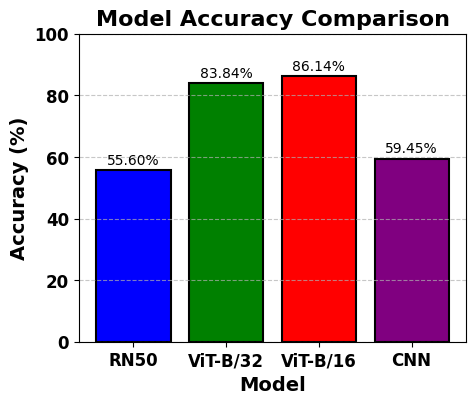

In [20]:
import matplotlib.pyplot as plt
acc1 = 55.60  # RN50
acc2 = 83.84  # ViT-B/32
acc3 = 86.14  # ViT-B/16
accuracy_convnet = 59.45  # CNN
acc_percentages = [acc1, acc2, acc3, accuracy_convnet]

models = ['RN50', 'ViT-B/32', 'ViT-B/16', 'CNN']

colors = ['blue', 'green', 'red', 'purple']
# 重新绘制柱状图

# 设置更大的图像尺寸
plt.figure(figsize=(5, 4))

# 绘制柱状图，增加边框宽度
bars = plt.bar(models, acc_percentages, color=colors, edgecolor='black', linewidth=1.5)

# 在柱状图上方添加数值标签
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.2f}%", ha='center', va='bottom')

# 设置标题和轴标签样式
plt.title('Model Accuracy Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Model', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=14, fontweight='bold')

# 设置纵轴范围和刻度样式
plt.ylim(0, 100)
plt.yticks(fontsize=12, fontweight='bold')

# 设置横轴刻度样式
plt.xticks(models, fontsize=12, fontweight='bold')

# 添加网格线，设置透明度
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 显示图表
plt.show()


In [19]:
torch.cuda.empty_cache()